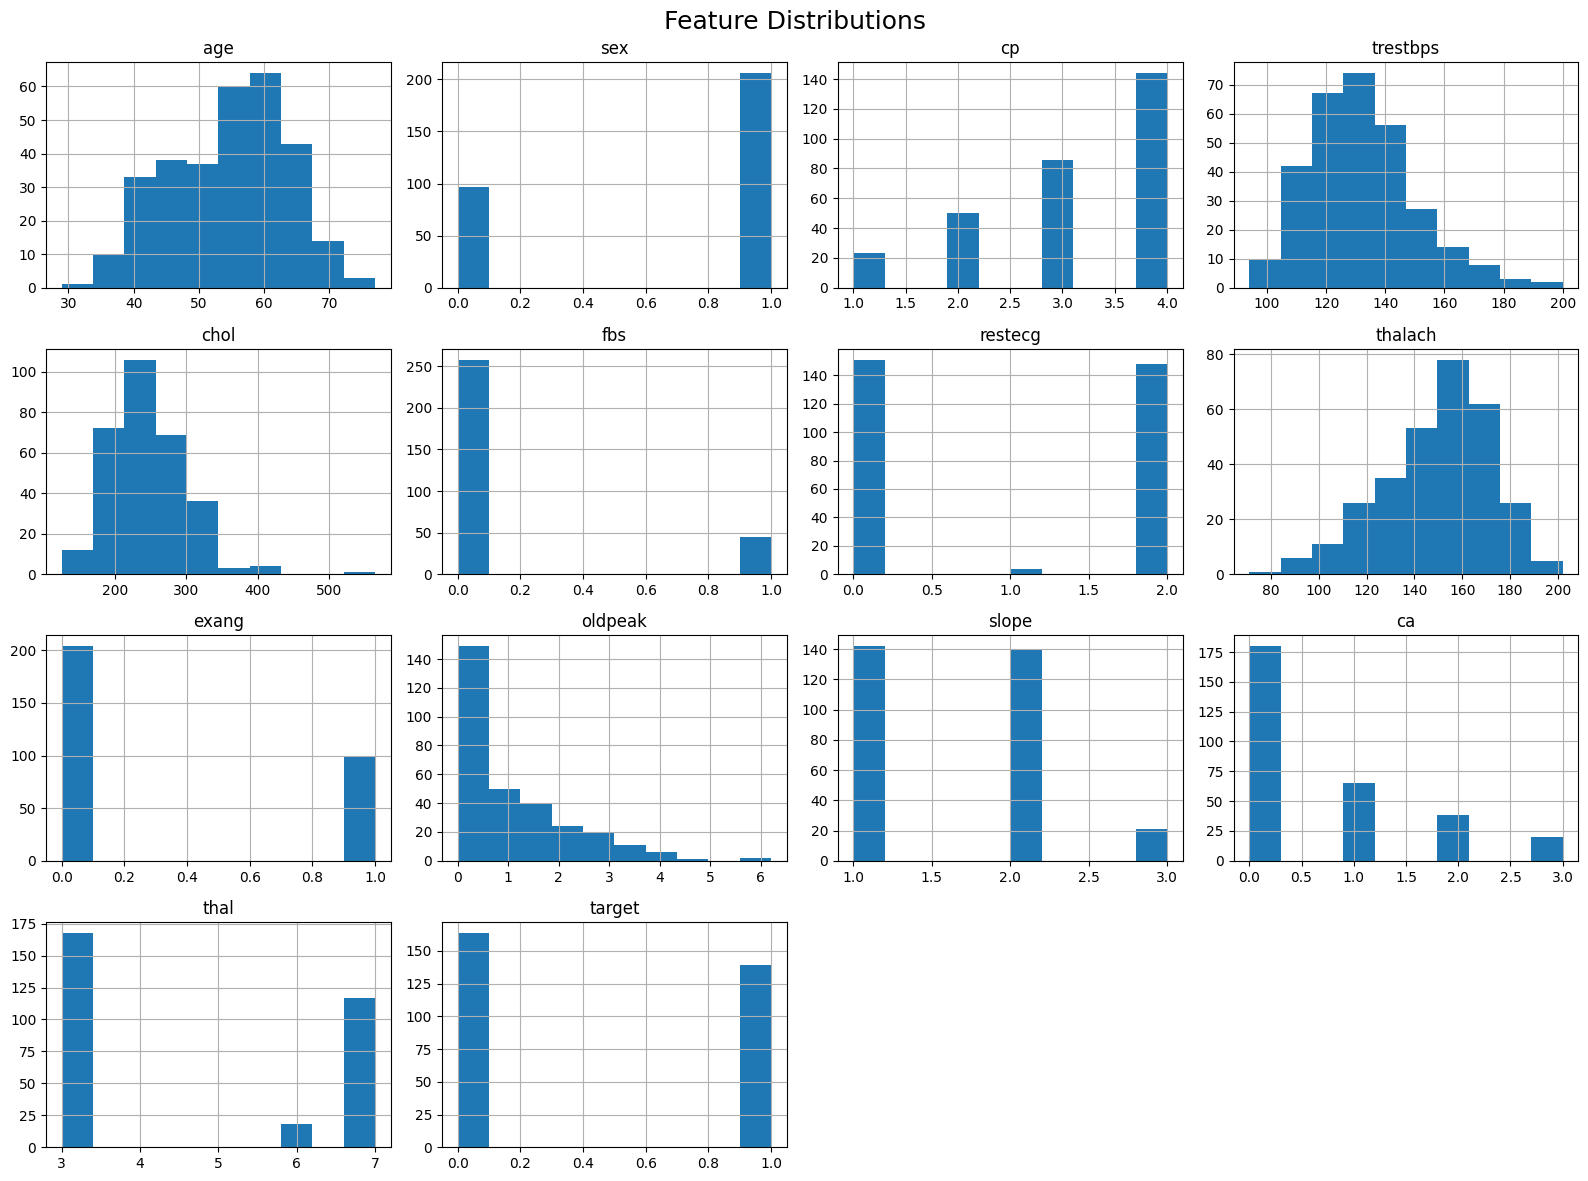

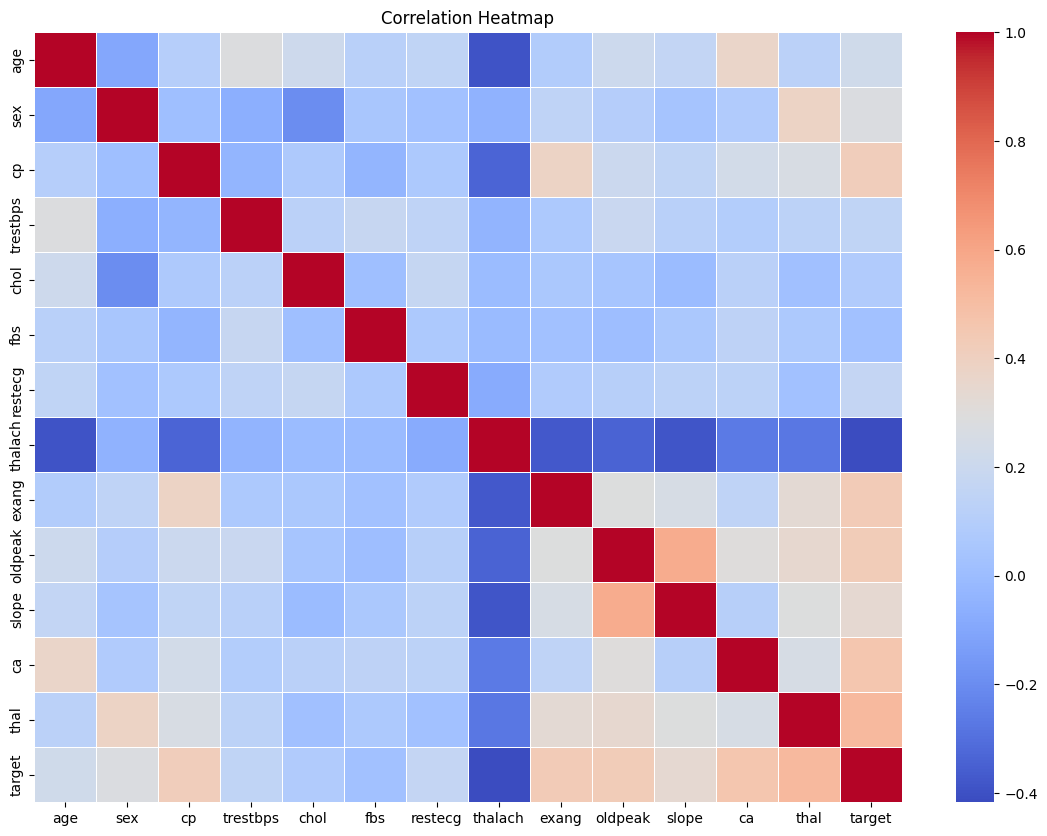

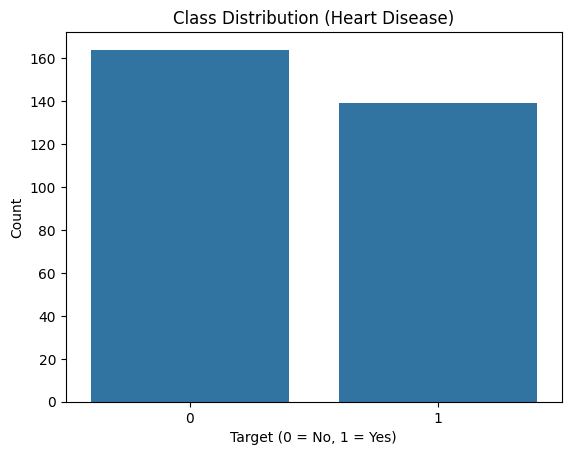

Raw data shape: (303, 14)
Processed data shape: (303, 21)

Class balance (proportion):
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [1]:
"""
TASK 1: Data Acquisition, Cleaning, Encoding, and EDA
Dataset: UCI Heart Disease (Cleveland)
Robust version that does NOT depend on broken metadata URLs
"""                                             # Module-level docstring explaining the task and dataset context

# =========================
# 1. IMPORT LIBRARIES
# =========================

import pandas as pd                              # Pandas for data loading, manipulation, and analysis
import numpy as np                               # NumPy for numerical operations and NaN handling
import matplotlib.pyplot as plt                  # Matplotlib for plotting graphs and visualizations
import seaborn as sns                            # Seaborn for advanced statistical visualizations
from pathlib import Path                         # Pathlib for OS-independent file and directory handling
import requests                                  # Requests library for HTTP requests (downloading dataset)
from io import StringIO                          # Converts string data into a file-like object for pandas

# =========================
# 2. SETUP DATA DIRECTORIES
# =========================

RAW_DATA_DIR = Path("data/raw")                  # Directory path for storing raw, unprocessed data
PROCESSED_DATA_DIR = Path("data/processed")      # Directory path for storing cleaned/processed data

RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)  # Create raw data directory if it does not exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)  # Create processed data directory if missing

# =========================
# 3. DOWNLOAD DATASET (NO COLUMN NAMES YET)
# =========================

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"  # UCI dataset URL

response = requests.get(DATA_URL)                # Send HTTP GET request to download the dataset
response.raise_for_status()                      # Raise error if the download failed (non-200 response)

# Load raw data without column names
raw_data = pd.read_csv(                          # Read CSV data into a pandas DataFrame
    StringIO(response.text),                     # Convert downloaded text into file-like object
    header=None                                  # Explicitly state that there are no column headers
)

# =========================
# 4. DYNAMIC COLUMN ASSIGNMENT (SCHEMA-DRIVEN)
# =========================

# Official UCI schema (used only as fallback mapping)
# This is unavoidable because UCI does not expose metadata reliably anymore
uci_schema = [                                   # List defining column names based on UCI documentation
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "target"
]

# Ensure column count matches schema
if raw_data.shape[1] != len(uci_schema):         # Check if dataset column count matches expected schema
    raise ValueError(                             # Raise error if mismatch is detected
        f"Column mismatch: expected {len(uci_schema)} "
        f"but got {raw_data.shape[1]}"
    )

raw_data.columns = uci_schema                    # Assign column names to the raw dataset

# Save raw dataset
raw_data.to_csv(RAW_DATA_DIR / "heart_disease_raw.csv", index=False)  # Save raw data for reproducibility

# =========================
# 5. HANDLE MISSING VALUES
# =========================

# Replace '?' with NaN
df = raw_data.replace("?", np.nan)               # Replace missing value placeholders with NumPy NaN

# Convert all columns to numeric
df = df.apply(pd.to_numeric)                     # Convert all values to numeric types

# Median imputation (robust for medical datasets)
df.fillna(df.median(), inplace=True)             # Fill missing values using median of each column

# =========================
# 6. TARGET VARIABLE TRANSFORMATION
# =========================

# Convert multi-class target into binary
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)  # 1 = disease present, 0 = no disease

# =========================
# 7. AUTOMATIC CATEGORICAL FEATURE DETECTION & ENCODING
# =========================

# Detect categorical features based on unique values
categorical_cols = [                             # List comprehension to detect categorical columns
    col for col in df.columns                    # Iterate through all columns
    if df[col].nunique() < 10 and col != "target"  # Treat columns with <10 unique values as categorical
]

# One-hot encoding
df_encoded = pd.get_dummies(                     # Perform one-hot encoding on categorical features
    df,
    columns=categorical_cols,                    # Columns to encode
    drop_first=True                              # Drop first category to avoid multicollinearity
)

# Save processed dataset
df_encoded.to_csv(                               # Save cleaned and encoded dataset
    PROCESSED_DATA_DIR / "heart_disease_cleaned.csv",
    index=False
)

# =========================
# 8. EXPLORATORY DATA ANALYSIS (EDA)
# =========================

# ---- HISTOGRAMS ----
df.hist(figsize=(16, 12))                        # Plot histograms for all features
plt.suptitle("Feature Distributions", fontsize=18)  # Main title for histogram grid
plt.tight_layout()                               # Adjust spacing to avoid overlapping plots
plt.show()                                      # Display histogram plots

# ---- CORRELATION HEATMAP ----
plt.figure(figsize=(14, 10))                    # Create new figure for heatmap
corr = df.corr()                                # Compute correlation matrix

sns.heatmap(                                    # Plot correlation heatmap
    corr,
    cmap="coolwarm",                            # Color scheme for positive/negative correlations
    annot=False,                                # Disable numeric annotations
    linewidths=0.5                              # Add grid lines between cells
)
plt.title("Correlation Heatmap")                # Title of the heatmap
plt.show()                                     # Display heatmap

# ---- CLASS BALANCE ----
sns.countplot(x="target", data=df)              # Plot count of each target class
plt.title("Class Distribution (Heart Disease)") # Title for class distribution plot
plt.xlabel("Target (0 = No, 1 = Yes)")           # X-axis label
plt.ylabel("Count")                             # Y-axis label
plt.show()                                     # Display class balance plot

# =========================
# 9. FINAL SUMMARY
# =========================

print("Raw data shape:", raw_data.shape)         # Print original dataset shape
print("Processed data shape:", df_encoded.shape)  # Print processed dataset shape
print("\nClass balance (proportion):")           # Header for class balance proportions
print(df["target"].value_counts(normalize=True))  # Print class distribution percentages
